In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance
from tqdm import tqdm

In [26]:
raw_df = pdr.get_data_yahoo("QQQ")
raw_df = raw_df.reset_index()

In [31]:
df = raw_df.copy()

window=20

df["ma"] = df["Adj Close"].rolling(window=window).mean()
df = df.iloc[window-1:]
df["deviation"] = df["Adj Close"]-df["ma"]
df["dev-squared"] = df["deviation"]*df["deviation"]
df["ma-dev-squared"] = df["dev-squared"].rolling(window=window).mean()
df= df.iloc[window-1:]
df["std-dev"] = df["ma-dev-squared"]**(1/2)

df.loc[df["Adj Close"] <= df["ma"]-2*df["std-dev"], "position"] = -2
df.loc[(df["ma"]-2*df["std-dev"] < df["Adj Close"]) & (df["Adj Close"] <= df["ma"]), "position"] = -1
df.loc[(df["ma"] <= df["Adj Close"]) & (df["Adj Close"] < df["ma"]+2*df["std-dev"]), "position"] = 1
df.loc[df["ma"]+2*df["std-dev"] <= df["Adj Close"], "position"] = 2

In [32]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ma,deviation,dev-squared,ma-dev-squared,std-dev,position
38,2017-09-27,145.000000,143.570007,143.929993,144.460007,33249400.0,139.861618,140.315462,-0.453844,0.205975,3.068656,1.751758,-1.0
39,2017-09-28,144.559998,143.779999,144.110001,144.410004,24149400.0,139.813217,140.319139,-0.505922,0.255957,2.947944,1.716958,-1.0
40,2017-09-29,145.559998,144.320007,144.699997,145.449997,43102400.0,140.820068,140.298288,0.521780,0.272255,2.512830,1.585191,1.0
41,2017-10-02,146.169998,144.929993,145.669998,145.580002,27351300.0,140.945953,140.293392,0.652561,0.425836,2.172581,1.473968,1.0
42,2017-10-03,146.059998,145.449997,145.770004,145.889999,19715200.0,141.246094,140.366781,0.879313,0.773191,2.110820,1.452866,1.0


In [33]:
seed = 1000000
buy_price = 0
holding = False
fee = 0.0016
for index, row in df.iterrows():
    if row["position"] == -2:
        if not holding:
            buy_price = row["Adj Close"]
            print(f"{row['Date']} buy :", buy_price)
            df.loc[index, "trade"] = "BUY"
            holding = True

    elif row["position"] == 2:
        if holding:
            sell_price = row["Adj Close"]
            print(f"{row['Date']} sell :", sell_price)
            print(f"수익률 : {int(((sell_price/buy_price) * (1-fee) - 1)*100)}%")
            holding = False
            df.loc[index, "trade"] = "SELL"
            seed = seed * (sell_price/buy_price) * (1-fee)

            print(f"총수익률 : {int((seed/1000000-1)*100)}%")
            print("===================")

    # 5%이상 손실날 때 손절
    elif holding and row["Adj Close"]/buy_price <= 0.9:
            sell_price = row["Adj Close"]
            print(f"{row['Date']} sell :", sell_price)
            print(f"손실률 : {int(((sell_price/buy_price) * (1-fee) - 1)*100)}%")
            holding = False
            df.loc[index, "trade"] = "STOP"
            seed = seed * (sell_price/buy_price) * (1-fee)

            print(f"총수익률 : {int((seed/1000000-1)*100)}%")
            print("===================")

    # 10% 이상 수익날 때 익절
    # elif holding and row["Adj Close"]/buy_price >= 1.1:
    #     sell_price = row["Adj Close"]
    #     print(f"{row['Date']} sell :", sell_price)
    #     holding = False
    #     seed = seed * (sell_price/buy_price) * (1-fee)

print(seed)

2018-02-08 00:00:00 buy : 148.87612915039062
2018-05-10 00:00:00 sell : 164.8311309814453
수익률 : 10%
총수익률 : 10%
2018-10-05 00:00:00 buy : 175.75425720214844
2018-11-19 00:00:00 sell : 158.1056365966797
손실률 : -10%
총수익률 : 0%
2018-12-20 00:00:00 buy : 148.57403564453125
2019-03-21 00:00:00 sell : 178.94989013671875
수익률 : 20%
총수익률 : 19%
2019-05-13 00:00:00 buy : 175.03897094726562
2021-01-21 00:00:00 sell : 323.7718200683594
수익률 : 84%
총수익률 : 120%
2021-03-04 00:00:00 buy : 301.6883850097656
2021-04-06 00:00:00 sell : 328.6109924316406
수익률 : 8%
총수익률 : 139%
2021-09-28 00:00:00 buy : 358.2784423828125
2022-03-08 00:00:00 sell : 322.3311462402344
손실률 : -10%
총수익률 : 115%
2153679.1668720217


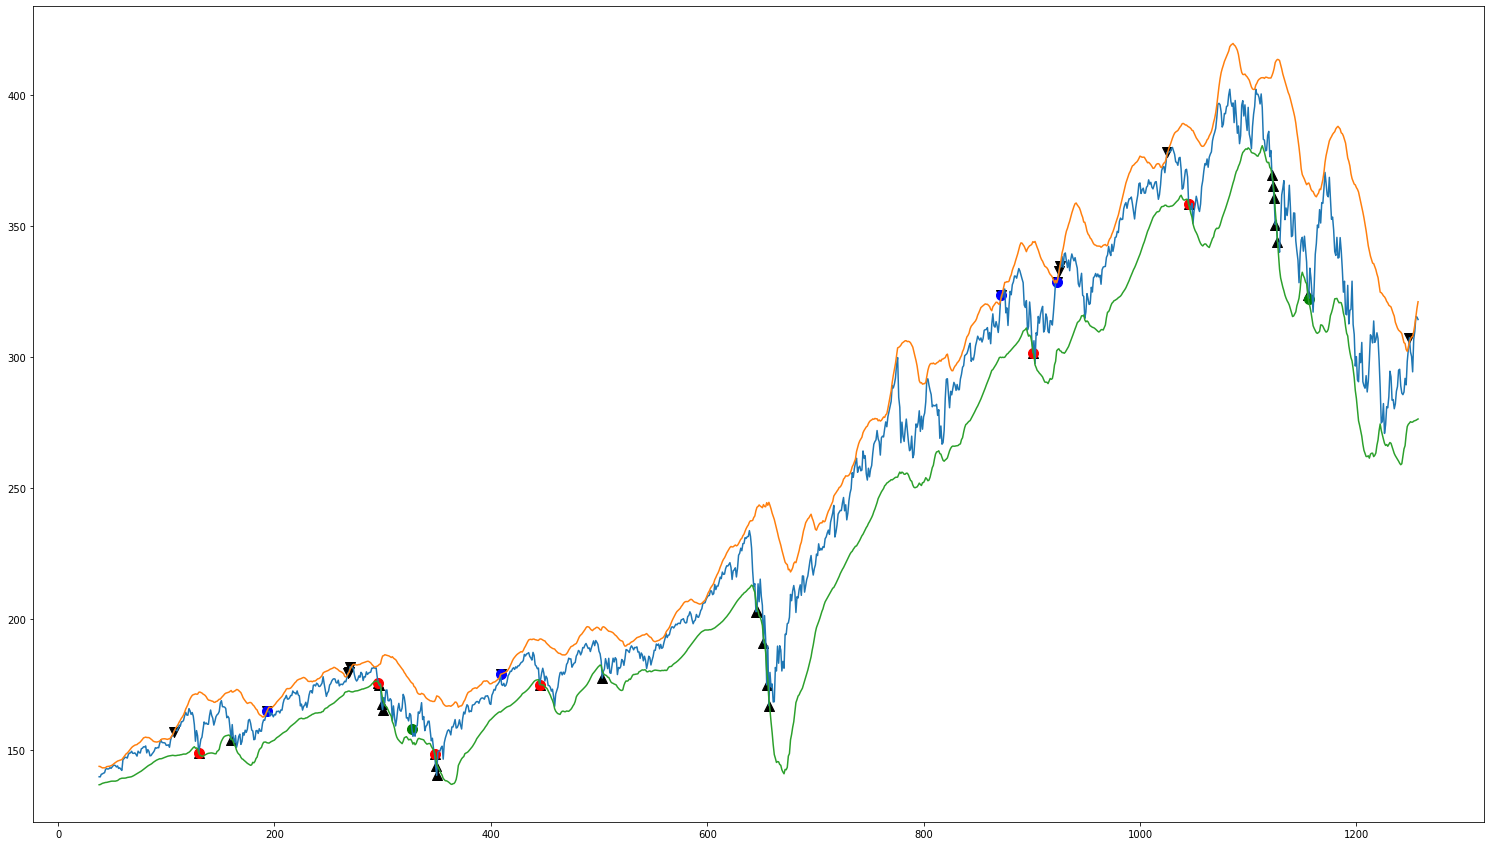

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 15))
plt.scatter(df[df["position"]==-2]["Adj Close"].reset_index()["index"], df[df["position"]==-2]["Adj Close"], color="black", s=100, marker="^")
plt.scatter(df[df["position"]==2]["Adj Close"].reset_index()["index"], df[df["position"]==2]["Adj Close"], color="black", s=100, marker="v")
plt.scatter(df[df["trade"]=="BUY"]["Adj Close"].reset_index()["index"], df[df["trade"]=="BUY"]["Adj Close"], color="red", s=100)
plt.scatter(df[df["trade"]=="SELL"]["Adj Close"].reset_index()["index"], df[df["trade"]=="SELL"]["Adj Close"], color="blue", s=100)
plt.scatter(df[df["trade"]=="STOP"]["Adj Close"].reset_index()["index"], df[df["trade"]=="STOP"]["Adj Close"], color="green", s=100)
plt.plot(df["Adj Close"])
plt.plot(df["ma"]+2*df["std-dev"])
plt.plot(df["ma"]-2*df["std-dev"])